In [1]:
import geopandas as gpd
import fiona
import osmnx as ox
import folium
from fiona.model import to_dict
from shapely.geometry import shape
from branca.colormap import LinearColormap
import numpy as np
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import random
from shapely.geometry import Polygon, Point

from skmob.tessellation.tilers import tiler
from skmob.utils.plot import plot_gdf
import requests
import pyproj
from shapely.ops import transform

In [2]:
tess_squared = tiler.get('squared', base_shape='Leuven, Belgium', meters=1000)
def get_convex_hull(tess):
    polygon = tess.at[0, 'geometry']
    for tile in tess['geometry']:
        polygon = polygon.union(tile)
    return polygon.convex_hull

poly_ch = get_convex_hull(tess_squared)

In [3]:
def Leuven_map():
    point = (50.849738563227824, 4.644786576420597)
    m = folium.Map(location=point, zoom_start = 12)
    return m

# DATA

In [4]:
traffico = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/traffic_data/traffic_model_leuven_baseline_2019.gpkg')

In [5]:
traffico_filtrato = traffico.drop_duplicates(subset='geometry_id')

traffic_df= traffico_filtrato[['from_node_id', 'to_node_id', 'flows_pae_aggr', 'flows_car_aggr']]
traffic_df.rename(columns={'from_node_id':'origin', 'to_node_id': 'destination'}, inplace=True)
traffic_df.head()

traffic_tess = traffico_filtrato[['geometry_id', 'geometry']]
traffic_tess.rename(columns={'geometry_id':'tile_ID'}, inplace=True)
traffic_tess = gpd.GeoDataFrame(traffic_tess).to_crs('epsg:4326')
traffic_tess.set_geometry(col=traffic_tess['geometry'])

origin_remove = []
for el in traffic_df['origin']:
    if el not in list(traffic_tess['tile_ID']):
       origin_remove.append(el)

destination_remove = []
for el in traffic_df['destination']:
    if el not in list(traffic_tess['tile_ID']):
       destination_remove.append(el)

traffic_df = traffic_df[~traffic_df['origin'].isin(origin_remove)]
traffic_df = traffic_df[~traffic_df['destination'].isin(destination_remove)]

df_per_colori = pd.merge(left=traffic_df, right=traffic_tess, right_on='tile_ID', left_on='origin')


C:\Users\and99\AppData\Local\Temp\ipykernel_6948\3231580134.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_df.rename(columns={'from_node_id':'origin', 'to_node_id': 'destination'}, inplace=True)
C:\Users\and99\AppData\Local\Temp\ipykernel_6948\3231580134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_tess.rename(columns={'geometry_id':'tile_ID'}, inplace=True)


In [6]:
zones_leuven = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/leuven_statsec.gpkg')
zones_leuven = zones_leuven.to_crs('epsg:4326')
zones_leuven.reset_index(inplace=True)

In [7]:
gdf_per_colori = gpd.GeoDataFrame(df_per_colori, geometry='geometry', crs="EPSG:4326")
gdf_per_colori.set_geometry(col=gdf_per_colori['geometry'])

gdf_zone = gpd.GeoDataFrame(zones_leuven, geometry='geometry', crs="EPSG:4326")
gdf_zone = gdf_zone.rename(columns={'geometry': 'zone_geometry'})
gdf_zone = gdf_zone.set_geometry(col=gdf_zone['zone_geometry'])


result = gpd.sjoin(left_df=gdf_per_colori, right_df=gdf_zone, how='inner')
gruppo = result.groupby(by=['index_right', 'zone_geometry', 'UIDN', 'SECNAAM']).sum().reset_index()

gruppo = gruppo[['index_right','zone_geometry', 'UIDN','SECNAAM','flows_pae_aggr','flows_car_aggr']]
gruppo.sort_values(by='flows_car_aggr', ascending=False)

C:\Users\and99\AppData\Local\Temp\ipykernel_6948\2477164722.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gruppo = result.groupby(by=['index_right', 'zone_geometry', 'UIDN', 'SECNAAM']).sum().reset_index()


,index_right,zone_geometry,UIDN,SECNAAM,flows_pae_aggr,flows_car_aggr
52,52,"MULTIPOLYGON (((4.70709 50.87073, 4.70710 50.8...",4065,LEUVEN NIEUW KWARTIER,66387.807870,52073.796141
0,0,"MULTIPOLYGON (((4.68850 50.89458, 4.68895 50.8...",19880,KAREELVELD,61415.171515,50092.932866
7,7,"MULTIPOLYGON (((4.67219 50.85271, 4.67166 50.8...",20061,CAMPUS HEVERLEE,58166.240732,47943.260852
54,54,"MULTIPOLYGON (((4.73454 50.85707, 4.73451 50.8...",4151,HAASRODE INDUSTRIEZONE,47980.271017,39787.843799
11,11,"MULTIPOLYGON (((4.69170 50.86141, 4.69208 50.8...",20600,HEVERLEE - WAVERSE BAAN,49015.012647,38376.404858
...,...,...,...,...,...,...
92,92,"MULTIPOLYGON (((4.71205 50.90404, 4.71207 50.9...",4116,DIJLEDREEF,1751.882176,1394.223155
65,65,"MULTIPOLYGON (((4.77038 50.88511, 4.77039 50.8...",4105,LOBERGEN,1252.257666,1053.753381
3,3,"MULTIPOLYGON (((4.69458 50.90685, 4.69460 50.9...",20057,KOKSIJDEWIJK,1147.122733,1017.642124
61,61,"MULTIPOLYGON (((4.70899 50.92329, 4.70892 50.9...",4077,PUTHOF,1166.016640,740.592876


In [8]:
# ciclabile/strada
cyclic = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/cycling_data/cycling_network.gpkg')
cyclic = cyclic.to_crs(epsg=4326)
nan_length = list(np.where(cyclic['LENGTE'].isna())[0])
cyclic.drop(nan_length, axis = 0, inplace = True)
cyclic.reset_index(inplace = True,  drop = True)

In [9]:
#info socio-dem
socio_dem_data = pd.read_excel('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/socio_demographic_data_leuven_2019.xlsx')
#drop nan zone
socio_dem_data.drop(np.where(socio_dem_data['CODSEC'].isna())[0][0], axis = 0 ,inplace=True)

In [10]:
#ciclabili per le zone selezionate
ind = set()
for i in range(len(cyclic)):
    z = zones_leuven['geometry']
    s = np.where(z.intersects(cyclic['geometry'][i]))[0]
    if len(s) > 0:
        ind.add(i)

In [11]:
leuven_cyclic = cyclic.iloc[list(ind), :]
utm = leuven_cyclic.estimate_utm_crs()
project = pyproj.Transformer.from_crs('4326', utm)

In [12]:
# off_street_parking
url = 'https://storageaccount11111111.blob.core.windows.net/container1/Leuven/parking_data_leuven/off_street_parking_supply_Leuven.json'
response = requests.get(url)
json_data = response.json()

results = json_data['JSON']['results']
normalized_data = pd.json_normalize(results)

df = pd.DataFrame(normalized_data)

In [13]:
# estraggo info dalla colonna bullets 
spots = []
cameras = []
accessibility = []
lift = []
height = []


for row in df['bullets']:
    spot_number = None
    camera_label = None
    accessibility_label = None
    lift_label = None
    height_label = None
    
    for item in row:
        label = item['label']
        if 'spots' in item['icon']:
            spot_number = int(''.join(filter(str.isdigit, label)))
        elif 'camera' in item['icon']:
            camera_label = label
        elif 'accessibility' in item['icon']:
            accessibility_label = label
        elif 'lift' in item['icon']:
            lift_label = label
        elif 'height' in item['icon']:
            height_label = label
    

    spots.append(spot_number)
    cameras.append(camera_label)
    accessibility.append(accessibility_label)
    lift.append(lift_label)
    height.append(height_label)

df['spots'] = spots
df['cameras'] = cameras
df['accessibility'] = accessibility
df['lift'] = lift
df['height'] = height

df = df.drop('bullets', axis=1)

In [14]:
geometry = [Point(xy) for xy in zip(df['coords.lng'], df['coords.lat'])]
off_parkings = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

columns_subset = ['pricing_type', 'free_bus', 'id', 'subtype', 'spots', 'lift', 'geometry']
off_parkings = off_parkings[columns_subset]
mapping = {'None': 0, 'Parking met lift': 1, True: 1, False:0}
off_parkings['lift'] = off_parkings['lift'].replace(mapping)
off_parkings['free_bus'] = off_parkings['free_bus'].replace(mapping)
off_parkings['lift'] = off_parkings['lift'].fillna(0)
off_parkings.shape

(43, 7)

In [15]:
on_street = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/parking_data/onstreet_parking_Leuven_2023.gpkg')
on_street = on_street.to_crs(epsg='4326')

In [16]:
stops = pd.read_csv('stops.csv')

In [17]:
coords = []
for index, rows in stops.iterrows():
    coords.append(Point(rows['stop_lon'], rows['stop_lat'],))

coords = gpd.GeoDataFrame(geometry=coords, crs = 'EPSG:4326')
coords['id'] = stops['stop_id']

In [18]:
#stops per le zone selezionate
ind = set()
for i in range(len(coords)):
    z = zones_leuven['geometry']
    s = np.where(z.contains(coords['geometry'][i]))[0]
    if len(s) > 0:
        ind.add(i)

In [19]:
leuven_stops = coords.iloc[list(ind), :]
leuven_stops.reset_index(inplace=True, drop = True)

In [20]:
import geopy.distance

In [21]:
utm_coords = leuven_stops.to_crs(utm)

In [22]:
utm_coords.reset_index(inplace = True, drop = True)

In [23]:
m = Leuven_map()
for ind, row in leuven_stops.iterrows():
    folium.Marker(row['geometry'].coords[0][::-1], popup=f"<id>{row['id']}").add_to(m)

In [24]:
ind = set()
for i,v in utm_coords.iterrows():
    if i not in ind:
        dist_arr = np.array(v['geometry'].distance(utm_coords['geometry']))
        low_arr = set(np.where(dist_arr < 60)[0])
        zero_dist = set(np.where(dist_arr == 0)[0])
        if len(zero_dist) > 0:
            low_arr = low_arr.difference(zero_dist)
        ind.update(low_arr)

In [25]:
ridotto = leuven_stops.drop(ind, axis = 0)
ridotto.reset_index(inplace=True, drop = True)
ridotto_utm = ridotto.to_crs(utm)

cyclic distance

In [26]:
cyclic['id'] = list(range(len(cyclic)))

start = []
end = []
geom = []

for i in cyclic['id']:  
    start.append(cyclic['geometry'][i].coords[0])
    end.append(cyclic['geometry'][i].coords[-1])
    
cyclic['start'] = start
cyclic['end'] = end
#dict key:coordinate - value:id
nodes = list(set(start).union(set(end)))
nodes.sort()
for point in nodes:
    geom.append(Point(point))

nodes_dict = {}
id_nodes = {}
for node in nodes:
    nodes_dict['id'] = nodes_dict.get('id', []) + [nodes.index(node)]
    nodes_dict['x']= nodes_dict.get('x', []) + [node[0]]
    nodes_dict['y']= nodes_dict.get('y', []) + [node[1]]

    id_nodes[(node[0], node[1])] = nodes.index(node)

    
cyclic_nodes = gpd.GeoDataFrame(nodes_dict, crs='epsg:4326', geometry= geom )

edges = {}

for i in cyclic['id']:
    edges['u'] = edges.get('u', []) + [id_nodes[cyclic['start'][i]]]
    edges['v'] = edges.get('v', []) + [id_nodes[cyclic['end'][i]]]
    edges['geometry'] = edges.get('geometry', []) + [cyclic['geometry'][i]]
    edges['length'] = edges.get('length', []) + [cyclic['LENGTE'][i]]
    edges['key'] = edges.get('key', []) + [i]

cyclic_edges = gpd.GeoDataFrame(edges, crs='epsg:4326')
cyclic_edges = cyclic_edges.set_index(['u', 'v', 'key'])
G = ox.graph_from_gdfs(cyclic_nodes, cyclic_edges)

G = nx.to_undirected(G)

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
lon, lat = (4.70053, 50.87984)
center_node = ox.nearest_nodes(G, X=lon, Y = lat)
G.nodes[center_node]

{'id': 2674, 'x': 4.70053984670537, 'y': 50.8798258193953}

In [27]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = 8.5 * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

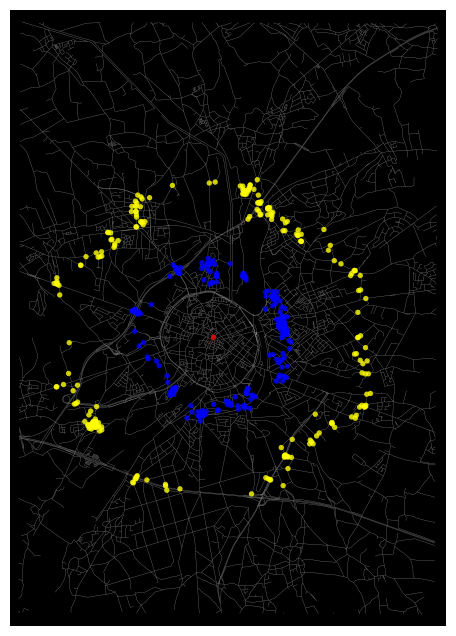

In [28]:
# color the nodes according to isochrone then plot the street network
distances = [15, 30]
node_colors = {}
node_found = []
color = {15:'blue', 30:'yellow', 45:'green'}

subgraph = nx.ego_graph(G, center_node, radius=30000, distance = 'time')
for time in distances:
    n = []
    for node in subgraph.nodes():
        w = nx.shortest_path_length(subgraph, center_node, node, weight= 'time')
        if time-1.5 <= w <= time+0.5:
            n.append(node)
            node_colors[node] = color[time]
        if node == center_node:
            node_colors[node] = 'red'

    node_found.append(n)

nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')



In [29]:
ch = []
for dist in node_found:
    points = []
    for point in dist:
        points.append(Point(G.nodes[point]['x'], G.nodes[point]['y']))
    points = gpd.GeoDataFrame(geometry = points)
    ch.append(get_convex_hull(points))

ch[1] = ch[1].difference(ch[0])

## Candidates computation

In [31]:
norm_traffic = (gruppo['flows_car_aggr'] - np.mean(gruppo['flows_car_aggr']))/ np.std(gruppo['flows_car_aggr'])
norm_inc = (socio_dem_data['inc_commuters'] - np.mean(socio_dem_data['inc_commuters']))/ np.std(socio_dem_data['inc_commuters'])
norm_out = (socio_dem_data['outg_commuters'] - np.mean(socio_dem_data['outg_commuters']))/ np.std(socio_dem_data['outg_commuters'])
norm_cit = (socio_dem_data['total_citizens'] - np.mean(socio_dem_data['total_citizens']))/ np.std(socio_dem_data['total_citizens'])

In [32]:
gruppo['norm_traffic'] = norm_traffic
socio_dem_data['norm_inc'] = norm_inc
socio_dem_data['norm_out'] = norm_out
socio_dem_data['norm_cit']  =norm_cit

In [53]:
transformed_parkings = off_parkings.to_crs(utm)
transform_cyclic = leuven_cyclic.to_crs(utm)
transformed_onstreet = on_street.to_crs(utm)

transform_cyclic.reset_index(inplace = True, drop = True)
leuven_cyclic.reset_index(inplace=True,  drop = True)

w_offpark = 0.1
w_onpark = 1
w_bike = 2
w_bus = 1
w_incomm = 0.8
w_outcomm = 0.2
w_total = 0.1
w_traffic = 1
w_hub = -1.5
w = [w_offpark, w_onpark, w_bike, w_bus ,w_incomm, w_outcomm, w_total, w_traffic, w_hub]

In [34]:
start_hubs = []
selected_zones = dict()

for i,r in off_parkings[off_parkings['lift'] > 0].loc[:, ['id', 'geometry']].iterrows():
    start_hubs.append(r.tolist())
    zona = np.where(r[-1].within(zones_leuven['geometry']))[0][0]
    #retrieve demographic information
    code = zones_leuven['CODSEC'][zona]
    selected_zones[code] = 1
    

In [47]:
def get_score(index, row, w):
    candidate = row['geometry']
    feat = {}
    #distance from off-street parking
    distance_offpark = max(100, np.min(candidate.distance(transformed_parkings['geometry'])))
    distance_offpark = min(distance_offpark, 2000)
    feat['nearest_offpark'] = 1/(distance_offpark) #penalize higher distances
    #distance from on-street parking
    distance_onpark = max(100, np.min(candidate.distance(transformed_onstreet['geometry'])))
    feat['nearest_onpark'] = 1/(distance_onpark) #penalize higher distances
    #distance from center by bike 
    if ch[0].contains(leuven_cyclic['geometry'][index]):
        dist_bike = 2.5
    elif ch[1].contains(leuven_cyclic['geometry'][index]):
        dist_bike = 1
    else:
        dist_bike = 0.3
    feat['distance_bike'] = dist_bike
    #bus stops
    distance_bus = max(20, np.min(candidate.distance(ridotto_utm['geometry'])))
    feat['nearest_bus'] = 1/distance_bus
    #find the city zone of the candidate street
    zona = np.where(candidate.intersects(zones_leuven['geometry'].to_crs(utm)))[0][0]
    #retrieve demographic information
    code = zones_leuven['CODSEC'][zona]
    uidn = zones_leuven['UIDN'][zona]
    #zona già coperta
    if code in selected_zones.keys():
        wd = np.subtract(w, 0.5)
        selected_zones[code] = selected_zones[code] +1
    else:
        wd = w
        selected_zones[code] = 1
    #density for the zone
    feat['total_citizens'] = float(socio_dem_data[socio_dem_data['CODSEC'] == code]['norm_cit'])
    #normalization for the number of inc/outc
    feat['outg_commuters'] =float(socio_dem_data[socio_dem_data['CODSEC'] == code]['norm_out'])
    feat['inc_commuters'] =float(socio_dem_data[socio_dem_data['CODSEC'] == code]['norm_inc'])
    #normalized traffic by zone
    feat['traffic'] = float(gruppo[gruppo['UIDN'] == uidn]['norm_traffic'])
    
    #penalize candidate near hubs
    #distance from nearest hub
    distance_hub = float('inf')
    for h in start_hubs:
        d = max(100, np.min(candidate.distance(h[1])))
        if d < distance_hub:
            distance_hub = d
    feat['hub'] = 1/min(distance_hub,1500)

    return np.dot(wd,list(feat.values()))


def update_scores(scores, new_hub, code):
    new_scores = []
    new_hub = transform_cyclic.iloc[new_hub[0], :]
    for idx, score in scores:
        #penalize candidate using the disance
        candidate = transform_cyclic.iloc[idx, :]
        distance = min(1000, candidate['geometry'].distance(new_hub['geometry']))
        #print(eps * 1/(distance + 1e-6))
        score = max(0, score - 1/(distance + 1e-6))
        #penilize the candidate using the zones
        zona = np.where(candidate['geometry'].intersects(zones_leuven['geometry'].to_crs(utm)))[0][0]
        #retrieve demographic information
        zone_code = zones_leuven['CODSEC'][zona]
        if code == zone_code:
            score -= 0.3
        new_scores.append([idx, score])
    return new_scores

### main loop

In [55]:
hubs = []
n_hubs = 150
#candidate ranking
scores = []
for idx, row in transform_cyclic.iterrows():
    scores.append([idx, get_score(idx, row, w)])


while n_hubs > 0:
    #sort scores by ranking
    scores = sorted(scores, key=lambda x:x[1], reverse= True)  
    #add candidate id highest score
    hubs.append(scores.pop(0))
    #check zone, add in the zone list
    top_score = transform_cyclic.iloc[scores[0][0], :]
    zona = np.where(top_score['geometry'].intersects(zones_leuven['geometry'].to_crs(utm)))[0][0]
    code = zones_leuven['CODSEC'][zona]
    selected_zones[code] = selected_zones.get(code, 0)+1
    n_hubs-=1
    #update rankings
    scores = update_scores(scores, hubs[-1], code)

In [57]:
hubs_ids = [t[0] for t in hubs]
m = Leuven_map()
for hub in hubs_ids:
    folium.GeoJson(leuven_cyclic['geometry'][hub]).add_to(m)
sh = off_parkings[off_parkings['lift'] > 0].loc[:, ['id', 'geometry']]
for p in sh['geometry']:
    y,x = p.coords.xy
    folium.Marker((x[-1],y[-1])).add_to(m)

In [58]:
m